# Übung 6: Transfer learning

Neuronal Netze benötigen oft eine große Menge an Trainingsdaten, damit es nicht zu overfitting kommt. Transfer learning erlaubt es, mit relativ geringen Datenmenge dennoch erfolgreiche große Netze zu trainieren. Dabei verwendet man ein bereits auf einen anderen Datensatz (z.b. ImageNet) vortrainiertes Netzwerk, und ersetzt nur das letzte Layer durch ein neues. In dieser Übung geht es darum, ein Netzwerk für die Erkennung von Geparden und Leoparden in der freien Wildbahn zu trainineren. 

## Daten laden

Lade die Daten hier herunter: http://tonic.imp.fu-berlin.de/cv_data/data.tar.gz

Die Daten wurde bereits in ein Trainings- und Validierungsset geteilt. Die Ordnerstruktur ist wie bei vielen Bildklassifierungsdatensetzen so aufgebaut. Es gibt zwei Unterordner für die Trainings- und Validierunsdaten. In diesen Ordnern liegen dann jeweils alle Bilder von einer Klasse in einem Unterordner mit dem Namen der Klasse.

Ein Beispiel: Die Trainingsbilder für die Klasse "cheetah" liegen in dem Unterordner train/cheetah

Diese Orderstruktur wird auch von dem in keras enhaltenen ImageDataGenerator unterstützt.

In [15]:
import tensorflow as tf
import itertools
from keras.backend.tensorflow_backend import set_session, get_session
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import binarize
import numpy as np

%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, decode_predictions
import warnings; warnings.simplefilter('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import optimizers


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',  cmap=plt.cm.Blues):
    """
    Source of this function: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    """ 
    Plots images with labels
    Quelle: https://github.com/deeplizard/Keras_Jupyter_Notebooks/blob/master/CNN.ipynb
    """
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')



In [5]:
batch_size = 32
image_input_size_task_1 = (128, 96)
image_input_size = (224, 224)
data_path = 'data/'

In [6]:
train_path = os.path.join(data_path, 'train')
valid_path = os.path.join(data_path, 'val')

classes = ('unknown', 'cheetah', 'leopard')

train_batches = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
    train_path, 
    target_size=image_input_size,
    classes=classes,
    batch_size=batch_size)

valid_batches = ImageDataGenerator(horizontal_flip=False).flow_from_directory(
    valid_path, 
    target_size=image_input_size,
    classes=classes,
    batch_size=batch_size,
    shuffle=False) 


Found 17797 images belonging to 3 classes.


Found 1915 images belonging to 3 classes.


## Training ohne transfer learning

Trainiere zuerst ein kleines Classifer-Netzwerk ohne transfer learning. Falls du keine Grafikkarte hast, solltest du nicht die volle Auflösung (siehe Variable image_input_size) verwenden, da das Training sonst zu lange dauert. Eine Bildgröße von 32x32 Pixeln wäre zum Beispiel möglich.

In [7]:
input_shape = (image_input_size[0], image_input_size[1], 3)
lr = 0.001

model = Sequential()

model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first", input_shape=input_shape)) # 224 / 2 = 112
model.add(Conv2D(256, (3, 3), strides=2, activation="relu"))    #56
model.add(Dropout(0.25))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(Conv2D(128, (3, 3), activation="relu"))                            
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))                         # 56 / 2 = 28

model.add(Conv2D(96, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(32, activation="relu"))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=lr),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 224, 112, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 55, 256)      2560      
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 55, 256)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 53, 256)      590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 107, 51, 128)      295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 107, 25, 64)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 105, 23, 96)       55392     
__________

In [5]:
# Fit the model 
model.fit_generator(
        train_batches,
        steps_per_epoch = 1800 // batch_size,
        epochs=10,
        validation_data = valid_batches,
        validation_steps = 250 // batch_size)


Epoch 1/10


 1/56 [..............................] - ETA: 3:02 - loss: 2.3128 - acc: 0.2500

 2/56 [>.............................] - ETA: 1:42 - loss: 3.4337 - acc: 0.4531

 3/56 [>.............................] - ETA: 1:15 - loss: 3.2845 - acc: 0.4792

 4/56 [=>............................] - ETA: 1:01 - loss: 4.0719 - acc: 0.4922

 5/56 [=>............................] - ETA: 53s - loss: 3.7244 - acc: 0.5062 

 6/56 [==>...........................] - ETA: 47s - loss: 3.2957 - acc: 0.5052

 7/56 [==>...........................] - ETA: 42s - loss: 2.9790 - acc: 0.4777

 8/56 [===>..........................] - ETA: 39s - loss: 2.7508 - acc: 0.4648

 9/56 [===>..........................] - ETA: 36s - loss: 2.5495 - acc: 0.4757

10/56 [====>.........................] - ETA: 34s - loss: 2.4764 - acc: 0.4844

11/56 [====>.........................] - ETA: 32s - loss: 2.3438 - acc: 0.4858

12/56 [=====>........................] - ETA: 31s - loss: 2.2393 - acc: 0.4688

13/56 [=====>........................] - ETA: 29s - loss: 2.1456 - acc: 0.4712

14/56 [======>.......................] - ETA: 28s - loss: 2.0582 - acc: 0.4665

15/56 [=======>......................] - ETA: 27s - loss: 1.9736 - acc: 0.4875

16/56 [=======>......................] - ETA: 25s - loss: 1.9116 - acc: 0.4961

17/56 [========>.....................] - ETA: 24s - loss: 1.8516 - acc: 0.5018

18/56 [========>.....................] - ETA: 23s - loss: 1.7927 - acc: 0.5122

19/56 [=========>....................] - ETA: 22s - loss: 1.7520 - acc: 0.5148

20/56 [=========>....................] - ETA: 22s - loss: 1.7102 - acc: 0.5203

21/56 [==========>...................] - ETA: 21s - loss: 1.6747 - acc: 0.5238

22/56 [==========>...................] - ETA: 20s - loss: 1.6427 - acc: 0.5256

23/56 [===========>..................] - ETA: 19s - loss: 1.6078 - acc: 0.5312

24/56 [===========>..................] - ETA: 18s - loss: 1.5778 - acc: 0.5339

25/56 [============>.................] - ETA: 18s - loss: 1.5463 - acc: 0.5437

26/56 [============>.................] - ETA: 17s - loss: 1.5113 - acc: 0.5541

27/56 [=============>................] - ETA: 16s - loss: 1.4932 - acc: 0.5579

28/56 [==============>...............] - ETA: 16s - loss: 1.4691 - acc: 0.5592

29/56 [==============>...............] - ETA: 15s - loss: 1.4481 - acc: 0.5625

30/56 [===============>..............] - ETA: 14s - loss: 1.4313 - acc: 0.5635

31/56 [===============>..............] - ETA: 14s - loss: 1.4164 - acc: 0.5625

32/56 [================>.............] - ETA: 13s - loss: 1.4008 - acc: 0.5605

33/56 [================>.............] - ETA: 12s - loss: 1.3837 - acc: 0.5644

34/56 [=================>............] - ETA: 12s - loss: 1.3662 - acc: 0.5662

35/56 [=================>............] - ETA: 11s - loss: 1.3587 - acc: 0.5687

36/56 [==================>...........] - ETA: 10s - loss: 1.3445 - acc: 0.5712

37/56 [==================>...........] - ETA: 10s - loss: 1.3357 - acc: 0.5709

38/56 [===================>..........] - ETA: 9s - loss: 1.3266 - acc: 0.5724 

39/56 [===================>..........] - ETA: 9s - loss: 1.3134 - acc: 0.5737

40/56 [====================>.........] - ETA: 8s - loss: 1.3020 - acc: 0.5750

41/56 [====================>.........] - ETA: 8s - loss: 1.2967 - acc: 0.5747

42/56 [=====================>........] - ETA: 7s - loss: 1.2914 - acc: 0.5714

43/56 [======================>.......] - ETA: 6s - loss: 1.2827 - acc: 0.5719

44/56 [======================>.......] - ETA: 6s - loss: 1.2751 - acc: 0.5746

45/56 [=======================>......] - ETA: 5s - loss: 1.2676 - acc: 0.5771

46/56 [=======================>......] - ETA: 5s - loss: 1.2603 - acc: 0.5815

47/56 [========================>.....] - ETA: 4s - loss: 1.2533 - acc: 0.5831

48/56 [========================>.....] - ETA: 4s - loss: 1.2460 - acc: 0.5872

49/56 [=========================>....] - ETA: 3s - loss: 1.2376 - acc: 0.5886

50/56 [=========================>....] - ETA: 3s - loss: 1.2265 - acc: 0.5913

51/56 [==========================>...] - ETA: 2s - loss: 1.2230 - acc: 0.5944

52/56 [==========================>...] - ETA: 2s - loss: 1.2215 - acc: 0.5938

53/56 [===========================>..] - ETA: 1s - loss: 1.2087 - acc: 0.5991

54/56 [===========================>..] - ETA: 1s - loss: 1.2007 - acc: 0.6007

55/56 [============================>.] - ETA: 0s - loss: 1.1932 - acc: 0.6028

56/56 [==============================] - 31s 549ms/step - loss: 1.1859 - acc: 0.6038 - val_loss: 1.1007 - val_acc: 0.0000e+00


Epoch 2/10


 1/56 [..............................] - ETA: 26s - loss: 0.9043 - acc: 0.5938

 2/56 [>.............................] - ETA: 25s - loss: 0.9131 - acc: 0.5625

 3/56 [>.............................] - ETA: 25s - loss: 0.8356 - acc: 0.6458

 4/56 [=>............................] - ETA: 24s - loss: 0.8377 - acc: 0.6406

 5/56 [=>............................] - ETA: 24s - loss: 0.8283 - acc: 0.6375

 6/56 [==>...........................] - ETA: 23s - loss: 0.8369 - acc: 0.6406

 7/56 [==>...........................] - ETA: 23s - loss: 0.8413 - acc: 0.6384

 8/56 [===>..........................] - ETA: 22s - loss: 0.8078 - acc: 0.6680

 9/56 [===>..........................] - ETA: 22s - loss: 0.8139 - acc: 0.6701

10/56 [====>.........................] - ETA: 21s - loss: 0.8346 - acc: 0.6594

11/56 [====>.........................] - ETA: 21s - loss: 0.8249 - acc: 0.6705

12/56 [=====>........................] - ETA: 20s - loss: 0.8316 - acc: 0.6693

13/56 [=====>........................] - ETA: 20s - loss: 0.8267 - acc: 0.6659

14/56 [======>.......................] - ETA: 19s - loss: 0.8147 - acc: 0.6786

15/56 [=======>......................] - ETA: 19s - loss: 0.8186 - acc: 0.6729

16/56 [=======>......................] - ETA: 18s - loss: 0.8133 - acc: 0.6719

17/56 [========>.....................] - ETA: 18s - loss: 0.8074 - acc: 0.6746

18/56 [========>.....................] - ETA: 17s - loss: 0.8101 - acc: 0.6771

19/56 [=========>....................] - ETA: 17s - loss: 0.8012 - acc: 0.6809

20/56 [=========>....................] - ETA: 16s - loss: 0.7890 - acc: 0.6859

21/56 [==========>...................] - ETA: 16s - loss: 0.8017 - acc: 0.6771

22/56 [==========>...................] - ETA: 16s - loss: 0.7979 - acc: 0.6804

23/56 [===========>..................] - ETA: 15s - loss: 0.8140 - acc: 0.6682

24/56 [===========>..................] - ETA: 15s - loss: 0.8207 - acc: 0.6638

25/56 [============>.................] - ETA: 14s - loss: 0.8211 - acc: 0.6673

26/56 [============>.................] - ETA: 14s - loss: 0.8262 - acc: 0.6632

27/56 [=============>................] - ETA: 13s - loss: 0.8292 - acc: 0.6630

28/56 [==============>...............] - ETA: 13s - loss: 0.8340 - acc: 0.6638

29/56 [==============>...............] - ETA: 12s - loss: 0.8324 - acc: 0.6668

30/56 [===============>..............] - ETA: 12s - loss: 0.8304 - acc: 0.6685

31/56 [===============>..............] - ETA: 11s - loss: 0.8305 - acc: 0.6702

32/56 [================>.............] - ETA: 11s - loss: 0.8320 - acc: 0.6668

33/56 [================>.............] - ETA: 10s - loss: 0.8282 - acc: 0.6703

34/56 [=================>............] - ETA: 10s - loss: 0.8354 - acc: 0.6643

35/56 [=================>............] - ETA: 9s - loss: 0.8303 - acc: 0.6659 

36/56 [==================>...........] - ETA: 9s - loss: 0.8286 - acc: 0.6656

37/56 [==================>...........] - ETA: 8s - loss: 0.8252 - acc: 0.6688

38/56 [===================>..........] - ETA: 8s - loss: 0.8233 - acc: 0.6676

39/56 [===================>..........] - ETA: 8s - loss: 0.8186 - acc: 0.6697

40/56 [====================>.........] - ETA: 7s - loss: 0.8225 - acc: 0.6670

41/56 [====================>.........] - ETA: 7s - loss: 0.8202 - acc: 0.6675

42/56 [=====================>........] - ETA: 6s - loss: 0.8137 - acc: 0.6717

43/56 [======================>.......] - ETA: 6s - loss: 0.8135 - acc: 0.6714

44/56 [======================>.......] - ETA: 5s - loss: 0.8128 - acc: 0.6703

45/56 [=======================>......] - ETA: 5s - loss: 0.8085 - acc: 0.6728

46/56 [=======================>......] - ETA: 4s - loss: 0.8100 - acc: 0.6717

47/56 [========================>.....] - ETA: 4s - loss: 0.8073 - acc: 0.6714

48/56 [========================>.....] - ETA: 3s - loss: 0.8063 - acc: 0.6730

49/56 [=========================>....] - ETA: 3s - loss: 0.8011 - acc: 0.6765

50/56 [=========================>....] - ETA: 2s - loss: 0.7989 - acc: 0.6780

51/56 [==========================>...] - ETA: 2s - loss: 0.8016 - acc: 0.6770

52/56 [==========================>...] - ETA: 1s - loss: 0.8053 - acc: 0.6754

53/56 [===========================>..] - ETA: 1s - loss: 0.8035 - acc: 0.6768

54/56 [===========================>..] - ETA: 0s - loss: 0.8022 - acc: 0.6793

55/56 [============================>.] - ETA: 0s - loss: 0.8011 - acc: 0.6794

56/56 [==============================] - 28s 499ms/step - loss: 0.7981 - acc: 0.6813 - val_loss: 1.0363 - val_acc: 0.2321


Epoch 3/10


 1/56 [..............................] - ETA: 26s - loss: 0.6962 - acc: 0.7500

 2/56 [>.............................] - ETA: 25s - loss: 0.8981 - acc: 0.6406

 3/56 [>.............................] - ETA: 25s - loss: 0.8132 - acc: 0.6979

 4/56 [=>............................] - ETA: 24s - loss: 0.8308 - acc: 0.6797

 5/56 [=>............................] - ETA: 24s - loss: 0.8131 - acc: 0.6875

 6/56 [==>...........................] - ETA: 23s - loss: 0.8286 - acc: 0.6719

 7/56 [==>...........................] - ETA: 23s - loss: 0.8175 - acc: 0.6741

 8/56 [===>..........................] - ETA: 22s - loss: 0.8191 - acc: 0.6680

 9/56 [===>..........................] - ETA: 22s - loss: 0.8187 - acc: 0.6632

10/56 [====>.........................] - ETA: 21s - loss: 0.8216 - acc: 0.6687

11/56 [====>.........................] - ETA: 21s - loss: 0.8241 - acc: 0.6676

12/56 [=====>........................] - ETA: 20s - loss: 0.8059 - acc: 0.6745

13/56 [=====>........................] - ETA: 20s - loss: 0.8022 - acc: 0.6755

14/56 [======>.......................] - ETA: 19s - loss: 0.7995 - acc: 0.6719

15/56 [=======>......................] - ETA: 19s - loss: 0.7998 - acc: 0.6771

16/56 [=======>......................] - ETA: 18s - loss: 0.8103 - acc: 0.6699

17/56 [========>.....................] - ETA: 18s - loss: 0.8188 - acc: 0.6654

18/56 [========>.....................] - ETA: 17s - loss: 0.8185 - acc: 0.6667

19/56 [=========>....................] - ETA: 17s - loss: 0.8175 - acc: 0.6661

20/56 [=========>....................] - ETA: 16s - loss: 0.8154 - acc: 0.6672

21/56 [==========>...................] - ETA: 16s - loss: 0.8105 - acc: 0.6696

22/56 [==========>...................] - ETA: 16s - loss: 0.8091 - acc: 0.6733

23/56 [===========>..................] - ETA: 15s - loss: 0.8098 - acc: 0.6698

24/56 [===========>..................] - ETA: 15s - loss: 0.7976 - acc: 0.6745

25/56 [============>.................] - ETA: 14s - loss: 0.7957 - acc: 0.6737

26/56 [============>.................] - ETA: 14s - loss: 0.8059 - acc: 0.6731

27/56 [=============>................] - ETA: 13s - loss: 0.8051 - acc: 0.6748

28/56 [==============>...............] - ETA: 13s - loss: 0.8058 - acc: 0.6741

29/56 [==============>...............] - ETA: 12s - loss: 0.8025 - acc: 0.6756

30/56 [===============>..............] - ETA: 12s - loss: 0.8014 - acc: 0.6771

31/56 [===============>..............] - ETA: 11s - loss: 0.8036 - acc: 0.6774

32/56 [================>.............] - ETA: 11s - loss: 0.8040 - acc: 0.6777

33/56 [================>.............] - ETA: 10s - loss: 0.7984 - acc: 0.6799

34/56 [=================>............] - ETA: 10s - loss: 0.8003 - acc: 0.6792

35/56 [=================>............] - ETA: 9s - loss: 0.8019 - acc: 0.6813 

36/56 [==================>...........] - ETA: 9s - loss: 0.8045 - acc: 0.6814

37/56 [==================>...........] - ETA: 8s - loss: 0.8048 - acc: 0.6824

38/56 [===================>..........] - ETA: 8s - loss: 0.8039 - acc: 0.6817

39/56 [===================>..........] - ETA: 8s - loss: 0.8091 - acc: 0.6787

40/56 [====================>.........] - ETA: 7s - loss: 0.8068 - acc: 0.6781

41/56 [====================>.........] - ETA: 7s - loss: 0.8026 - acc: 0.6791

42/56 [=====================>........] - ETA: 6s - loss: 0.8036 - acc: 0.6778

43/56 [======================>.......] - ETA: 6s - loss: 0.8028 - acc: 0.6766

44/56 [======================>.......] - ETA: 5s - loss: 0.8023 - acc: 0.6776

45/56 [=======================>......] - ETA: 5s - loss: 0.7982 - acc: 0.6819

46/56 [=======================>......] - ETA: 4s - loss: 0.7960 - acc: 0.6821

47/56 [========================>.....] - ETA: 4s - loss: 0.7910 - acc: 0.6842

48/56 [========================>.....] - ETA: 3s - loss: 0.7881 - acc: 0.6862

49/56 [=========================>....] - ETA: 3s - loss: 0.7901 - acc: 0.6869

50/56 [=========================>....] - ETA: 2s - loss: 0.7885 - acc: 0.6881

51/56 [==========================>...] - ETA: 2s - loss: 0.7844 - acc: 0.6893

52/56 [==========================>...] - ETA: 1s - loss: 0.7823 - acc: 0.6893

53/56 [===========================>..] - ETA: 1s - loss: 0.7824 - acc: 0.6899

54/56 [===========================>..] - ETA: 0s - loss: 0.7839 - acc: 0.6887

55/56 [============================>.] - ETA: 0s - loss: 0.7842 - acc: 0.6875

56/56 [==============================] - 28s 499ms/step - loss: 0.7795 - acc: 0.6897 - val_loss: 1.0969 - val_acc: 0.3616


Epoch 4/10


 1/56 [..............................] - ETA: 26s - loss: 0.6561 - acc: 0.7188

 2/56 [>.............................] - ETA: 25s - loss: 0.6095 - acc: 0.7656

 3/56 [>.............................] - ETA: 25s - loss: 0.6461 - acc: 0.7500

 4/56 [=>............................] - ETA: 24s - loss: 0.6355 - acc: 0.7578

 5/56 [=>............................] - ETA: 24s - loss: 0.7157 - acc: 0.7312

 6/56 [==>...........................] - ETA: 23s - loss: 0.6983 - acc: 0.7240

 7/56 [==>...........................] - ETA: 23s - loss: 0.7169 - acc: 0.7143

 8/56 [===>..........................] - ETA: 22s - loss: 0.7270 - acc: 0.7109

 9/56 [===>..........................] - ETA: 22s - loss: 0.7194 - acc: 0.7222

10/56 [====>.........................] - ETA: 21s - loss: 0.7066 - acc: 0.7406

11/56 [====>.........................] - ETA: 21s - loss: 0.7232 - acc: 0.7301

12/56 [=====>........................] - ETA: 20s - loss: 0.7261 - acc: 0.7344

13/56 [=====>........................] - ETA: 20s - loss: 0.7069 - acc: 0.7404

14/56 [======>.......................] - ETA: 19s - loss: 0.7120 - acc: 0.7388

15/56 [=======>......................] - ETA: 19s - loss: 0.7086 - acc: 0.7438

16/56 [=======>......................] - ETA: 18s - loss: 0.7176 - acc: 0.7441

17/56 [========>.....................] - ETA: 18s - loss: 0.7264 - acc: 0.7371

18/56 [========>.....................] - ETA: 17s - loss: 0.7220 - acc: 0.7378

19/56 [=========>....................] - ETA: 17s - loss: 0.7192 - acc: 0.7368

20/56 [=========>....................] - ETA: 17s - loss: 0.7239 - acc: 0.7344

21/56 [==========>...................] - ETA: 16s - loss: 0.7238 - acc: 0.7321

22/56 [==========>...................] - ETA: 16s - loss: 0.7278 - acc: 0.7301

23/56 [===========>..................] - ETA: 15s - loss: 0.7304 - acc: 0.7269

24/56 [===========>..................] - ETA: 15s - loss: 0.7368 - acc: 0.7266

25/56 [============>.................] - ETA: 14s - loss: 0.7342 - acc: 0.7250

26/56 [============>.................] - ETA: 14s - loss: 0.7269 - acc: 0.7296

27/56 [=============>................] - ETA: 13s - loss: 0.7236 - acc: 0.7292

28/56 [==============>...............] - ETA: 13s - loss: 0.7249 - acc: 0.7321

29/56 [==============>...............] - ETA: 12s - loss: 0.7236 - acc: 0.7306

30/56 [===============>..............] - ETA: 12s - loss: 0.7162 - acc: 0.7365

31/56 [===============>..............] - ETA: 11s - loss: 0.7089 - acc: 0.7389

32/56 [================>.............] - ETA: 11s - loss: 0.7105 - acc: 0.7383

33/56 [================>.............] - ETA: 10s - loss: 0.7062 - acc: 0.7424

34/56 [=================>............] - ETA: 10s - loss: 0.7139 - acc: 0.7417

35/56 [=================>............] - ETA: 9s - loss: 0.7095 - acc: 0.7446 

36/56 [==================>...........] - ETA: 9s - loss: 0.7113 - acc: 0.7439

37/56 [==================>...........] - ETA: 8s - loss: 0.7081 - acc: 0.7449

38/56 [===================>..........] - ETA: 8s - loss: 0.7079 - acc: 0.7451

39/56 [===================>..........] - ETA: 8s - loss: 0.7040 - acc: 0.7476

40/56 [====================>.........] - ETA: 7s - loss: 0.7038 - acc: 0.7492

41/56 [====================>.........] - ETA: 7s - loss: 0.7061 - acc: 0.7492

42/56 [=====================>........] - ETA: 6s - loss: 0.7047 - acc: 0.7507

43/56 [======================>.......] - ETA: 6s - loss: 0.7029 - acc: 0.7507

44/56 [======================>.......] - ETA: 5s - loss: 0.7036 - acc: 0.7500

45/56 [=======================>......] - ETA: 5s - loss: 0.6987 - acc: 0.7521

46/56 [=======================>......] - ETA: 4s - loss: 0.6953 - acc: 0.7534

47/56 [========================>.....] - ETA: 4s - loss: 0.6936 - acc: 0.7540

48/56 [========================>.....] - ETA: 3s - loss: 0.6957 - acc: 0.7552

49/56 [=========================>....] - ETA: 3s - loss: 0.6906 - acc: 0.7570

50/56 [=========================>....] - ETA: 2s - loss: 0.6844 - acc: 0.7600

51/56 [==========================>...] - ETA: 2s - loss: 0.6866 - acc: 0.7598

52/56 [==========================>...] - ETA: 1s - loss: 0.6900 - acc: 0.7590

53/56 [===========================>..] - ETA: 1s - loss: 0.6906 - acc: 0.7588

54/56 [===========================>..] - ETA: 0s - loss: 0.6924 - acc: 0.7575

55/56 [============================>.] - ETA: 0s - loss: 0.6898 - acc: 0.7591

56/56 [==============================] - 28s 499ms/step - loss: 0.6863 - acc: 0.7612 - val_loss: 0.9122 - val_acc: 0.4777


Epoch 5/10


 1/56 [..............................] - ETA: 26s - loss: 0.5339 - acc: 0.8438

 2/56 [>.............................] - ETA: 25s - loss: 0.5489 - acc: 0.8281

 3/56 [>.............................] - ETA: 25s - loss: 0.5477 - acc: 0.8021

 4/56 [=>............................] - ETA: 24s - loss: 0.5826 - acc: 0.7656

 5/56 [=>............................] - ETA: 24s - loss: 0.6225 - acc: 0.7500

 6/56 [==>...........................] - ETA: 23s - loss: 0.6395 - acc: 0.7604

 7/56 [==>...........................] - ETA: 23s - loss: 0.6304 - acc: 0.7589

 8/56 [===>..........................] - ETA: 22s - loss: 0.6223 - acc: 0.7656

 9/56 [===>..........................] - ETA: 22s - loss: 0.6365 - acc: 0.7604

10/56 [====>.........................] - ETA: 21s - loss: 0.6596 - acc: 0.7594

11/56 [====>.........................] - ETA: 21s - loss: 0.6558 - acc: 0.7614

12/56 [=====>........................] - ETA: 20s - loss: 0.6581 - acc: 0.7604

13/56 [=====>........................] - ETA: 20s - loss: 0.6591 - acc: 0.7620

14/56 [======>.......................] - ETA: 19s - loss: 0.6615 - acc: 0.7612

15/56 [=======>......................] - ETA: 19s - loss: 0.6655 - acc: 0.7542

16/56 [=======>......................] - ETA: 18s - loss: 0.6683 - acc: 0.7539

17/56 [========>.....................] - ETA: 18s - loss: 0.6642 - acc: 0.7574

18/56 [========>.....................] - ETA: 17s - loss: 0.6638 - acc: 0.7604

19/56 [=========>....................] - ETA: 17s - loss: 0.6642 - acc: 0.7582

20/56 [=========>....................] - ETA: 16s - loss: 0.6588 - acc: 0.7609

21/56 [==========>...................] - ETA: 16s - loss: 0.6596 - acc: 0.7604

22/56 [==========>...................] - ETA: 16s - loss: 0.6743 - acc: 0.7557

23/56 [===========>..................] - ETA: 15s - loss: 0.6743 - acc: 0.7582

24/56 [===========>..................] - ETA: 15s - loss: 0.6757 - acc: 0.7565

25/56 [============>.................] - ETA: 14s - loss: 0.6741 - acc: 0.7550

26/56 [============>.................] - ETA: 14s - loss: 0.6799 - acc: 0.7500

27/56 [=============>................] - ETA: 13s - loss: 0.6708 - acc: 0.7546

28/56 [==============>...............] - ETA: 13s - loss: 0.6763 - acc: 0.7511

29/56 [==============>...............] - ETA: 12s - loss: 0.6904 - acc: 0.7500

30/56 [===============>..............] - ETA: 12s - loss: 0.6913 - acc: 0.7479

31/56 [===============>..............] - ETA: 11s - loss: 0.6945 - acc: 0.7460

32/56 [================>.............] - ETA: 11s - loss: 0.6921 - acc: 0.7441

33/56 [================>.............] - ETA: 10s - loss: 0.6892 - acc: 0.7462

34/56 [=================>............] - ETA: 10s - loss: 0.6805 - acc: 0.7509

35/56 [=================>............] - ETA: 9s - loss: 0.6842 - acc: 0.7491 

36/56 [==================>...........] - ETA: 9s - loss: 0.6798 - acc: 0.7509

37/56 [==================>...........] - ETA: 8s - loss: 0.6727 - acc: 0.7542

38/56 [===================>..........] - ETA: 8s - loss: 0.6673 - acc: 0.7558

39/56 [===================>..........] - ETA: 8s - loss: 0.6671 - acc: 0.7564

40/56 [====================>.........] - ETA: 7s - loss: 0.6706 - acc: 0.7562

41/56 [====================>.........] - ETA: 7s - loss: 0.6688 - acc: 0.7561

42/56 [=====================>........] - ETA: 6s - loss: 0.6669 - acc: 0.7567

43/56 [======================>.......] - ETA: 6s - loss: 0.6669 - acc: 0.7565

44/56 [======================>.......] - ETA: 5s - loss: 0.6634 - acc: 0.7585

45/56 [=======================>......] - ETA: 5s - loss: 0.6623 - acc: 0.7569

46/56 [=======================>......] - ETA: 4s - loss: 0.6576 - acc: 0.7595

47/56 [========================>.....] - ETA: 4s - loss: 0.6582 - acc: 0.7593

48/56 [========================>.....] - ETA: 3s - loss: 0.6566 - acc: 0.7604

49/56 [=========================>....] - ETA: 3s - loss: 0.6550 - acc: 0.7608

50/56 [=========================>....] - ETA: 2s - loss: 0.6575 - acc: 0.7588

51/56 [==========================>...] - ETA: 2s - loss: 0.6557 - acc: 0.7586

52/56 [==========================>...] - ETA: 1s - loss: 0.6539 - acc: 0.7578

53/56 [===========================>..] - ETA: 1s - loss: 0.6514 - acc: 0.7583

54/56 [===========================>..] - ETA: 0s - loss: 0.6472 - acc: 0.7604

55/56 [============================>.] - ETA: 0s - loss: 0.6441 - acc: 0.7619

56/56 [==============================] - 28s 499ms/step - loss: 0.6440 - acc: 0.7617 - val_loss: 1.1140 - val_acc: 0.4821


Epoch 6/10


 1/56 [..............................] - ETA: 26s - loss: 0.9865 - acc: 0.6562

 2/56 [>.............................] - ETA: 25s - loss: 0.7375 - acc: 0.7344

 3/56 [>.............................] - ETA: 25s - loss: 0.7414 - acc: 0.7188

 4/56 [=>............................] - ETA: 24s - loss: 0.6980 - acc: 0.7344

 5/56 [=>............................] - ETA: 24s - loss: 0.6771 - acc: 0.7500

 6/56 [==>...........................] - ETA: 23s - loss: 0.6542 - acc: 0.7604

 7/56 [==>...........................] - ETA: 23s - loss: 0.6495 - acc: 0.7723

 8/56 [===>..........................] - ETA: 22s - loss: 0.6531 - acc: 0.7656

 9/56 [===>..........................] - ETA: 22s - loss: 0.6779 - acc: 0.7500

10/56 [====>.........................] - ETA: 21s - loss: 0.6862 - acc: 0.7469

11/56 [====>.........................] - ETA: 21s - loss: 0.6836 - acc: 0.7472

12/56 [=====>........................] - ETA: 20s - loss: 0.6894 - acc: 0.7448

13/56 [=====>........................] - ETA: 20s - loss: 0.6822 - acc: 0.7452

14/56 [======>.......................] - ETA: 19s - loss: 0.6614 - acc: 0.7567

15/56 [=======>......................] - ETA: 19s - loss: 0.6657 - acc: 0.7500

16/56 [=======>......................] - ETA: 18s - loss: 0.6563 - acc: 0.7559

17/56 [========>.....................] - ETA: 18s - loss: 0.6499 - acc: 0.7537

18/56 [========>.....................] - ETA: 17s - loss: 0.6542 - acc: 0.7500

19/56 [=========>....................] - ETA: 17s - loss: 0.6470 - acc: 0.7549

20/56 [=========>....................] - ETA: 16s - loss: 0.6500 - acc: 0.7578

21/56 [==========>...................] - ETA: 16s - loss: 0.6392 - acc: 0.7649

22/56 [==========>...................] - ETA: 16s - loss: 0.6301 - acc: 0.7685

23/56 [===========>..................] - ETA: 15s - loss: 0.6361 - acc: 0.7649

24/56 [===========>..................] - ETA: 15s - loss: 0.6419 - acc: 0.7656

25/56 [============>.................] - ETA: 14s - loss: 0.6467 - acc: 0.7638

26/56 [============>.................] - ETA: 14s - loss: 0.6468 - acc: 0.7632

27/56 [=============>................] - ETA: 13s - loss: 0.6418 - acc: 0.7674

28/56 [==============>...............] - ETA: 13s - loss: 0.6398 - acc: 0.7690

29/56 [==============>...............] - ETA: 12s - loss: 0.6371 - acc: 0.7705

30/56 [===============>..............] - ETA: 12s - loss: 0.6367 - acc: 0.7688

31/56 [===============>..............] - ETA: 11s - loss: 0.6319 - acc: 0.7692

32/56 [================>.............] - ETA: 11s - loss: 0.6306 - acc: 0.7686

33/56 [================>.............] - ETA: 10s - loss: 0.6217 - acc: 0.7727

34/56 [=================>............] - ETA: 10s - loss: 0.6300 - acc: 0.7684

35/56 [=================>............] - ETA: 9s - loss: 0.6421 - acc: 0.7652 

36/56 [==================>...........] - ETA: 9s - loss: 0.6401 - acc: 0.7656

37/56 [==================>...........] - ETA: 8s - loss: 0.6415 - acc: 0.7669

38/56 [===================>..........] - ETA: 8s - loss: 0.6421 - acc: 0.7640

39/56 [===================>..........] - ETA: 8s - loss: 0.6402 - acc: 0.7636

40/56 [====================>.........] - ETA: 7s - loss: 0.6369 - acc: 0.7656

41/56 [====================>.........] - ETA: 7s - loss: 0.6311 - acc: 0.7691

42/56 [=====================>........] - ETA: 6s - loss: 0.6269 - acc: 0.7708

43/56 [======================>.......] - ETA: 6s - loss: 0.6259 - acc: 0.7711

44/56 [======================>.......] - ETA: 5s - loss: 0.6224 - acc: 0.7734

45/56 [=======================>......] - ETA: 5s - loss: 0.6200 - acc: 0.7729

46/56 [=======================>......] - ETA: 4s - loss: 0.6218 - acc: 0.7704

47/56 [========================>.....] - ETA: 4s - loss: 0.6181 - acc: 0.7719

48/56 [========================>.....] - ETA: 3s - loss: 0.6244 - acc: 0.7689

49/56 [=========================>....] - ETA: 3s - loss: 0.6204 - acc: 0.7704

50/56 [=========================>....] - ETA: 2s - loss: 0.6191 - acc: 0.7712

51/56 [==========================>...] - ETA: 2s - loss: 0.6148 - acc: 0.7727

52/56 [==========================>...] - ETA: 1s - loss: 0.6170 - acc: 0.7722

53/56 [===========================>..] - ETA: 1s - loss: 0.6192 - acc: 0.7718

54/56 [===========================>..] - ETA: 0s - loss: 0.6161 - acc: 0.7737

55/56 [============================>.] - ETA: 0s - loss: 0.6165 - acc: 0.7733

56/56 [==============================] - 28s 499ms/step - loss: 0.6226 - acc: 0.7706 - val_loss: 0.8501 - val_acc: 0.5179


Epoch 7/10


 1/56 [..............................] - ETA: 26s - loss: 0.5908 - acc: 0.7812

 2/56 [>.............................] - ETA: 25s - loss: 0.5883 - acc: 0.8125

 3/56 [>.............................] - ETA: 25s - loss: 0.6313 - acc: 0.8021

 4/56 [=>............................] - ETA: 24s - loss: 0.6297 - acc: 0.7891

 5/56 [=>............................] - ETA: 24s - loss: 0.6193 - acc: 0.7688

 6/56 [==>...........................] - ETA: 23s - loss: 0.5871 - acc: 0.7865

 7/56 [==>...........................] - ETA: 23s - loss: 0.6063 - acc: 0.7723

 8/56 [===>..........................] - ETA: 22s - loss: 0.5886 - acc: 0.7773

 9/56 [===>..........................] - ETA: 22s - loss: 0.5820 - acc: 0.7812

10/56 [====>.........................] - ETA: 21s - loss: 0.5966 - acc: 0.7719

11/56 [====>.........................] - ETA: 21s - loss: 0.5942 - acc: 0.7784

12/56 [=====>........................] - ETA: 20s - loss: 0.5831 - acc: 0.7786

13/56 [=====>........................] - ETA: 20s - loss: 0.5975 - acc: 0.7788

14/56 [======>.......................] - ETA: 19s - loss: 0.6208 - acc: 0.7768

15/56 [=======>......................] - ETA: 19s - loss: 0.6112 - acc: 0.7833

16/56 [=======>......................] - ETA: 18s - loss: 0.6007 - acc: 0.7891

17/56 [========>.....................] - ETA: 18s - loss: 0.5919 - acc: 0.7941

18/56 [========>.....................] - ETA: 17s - loss: 0.5950 - acc: 0.7917

19/56 [=========>....................] - ETA: 17s - loss: 0.5797 - acc: 0.7977

20/56 [=========>....................] - ETA: 17s - loss: 0.5781 - acc: 0.7969

21/56 [==========>...................] - ETA: 16s - loss: 0.5761 - acc: 0.7961

22/56 [==========>...................] - ETA: 16s - loss: 0.5767 - acc: 0.7940

23/56 [===========>..................] - ETA: 15s - loss: 0.5746 - acc: 0.7962

24/56 [===========>..................] - ETA: 15s - loss: 0.5679 - acc: 0.7982

25/56 [============>.................] - ETA: 14s - loss: 0.5636 - acc: 0.8013

26/56 [============>.................] - ETA: 14s - loss: 0.5662 - acc: 0.7969

27/56 [=============>................] - ETA: 13s - loss: 0.5584 - acc: 0.7951

28/56 [==============>...............] - ETA: 13s - loss: 0.5685 - acc: 0.7935

29/56 [==============>...............] - ETA: 12s - loss: 0.5704 - acc: 0.7909

30/56 [===============>..............] - ETA: 12s - loss: 0.5625 - acc: 0.7948

31/56 [===============>..............] - ETA: 11s - loss: 0.5586 - acc: 0.7954

32/56 [================>.............] - ETA: 11s - loss: 0.5629 - acc: 0.7949

33/56 [================>.............] - ETA: 10s - loss: 0.5543 - acc: 0.7992

34/56 [=================>............] - ETA: 10s - loss: 0.5527 - acc: 0.7996

35/56 [=================>............] - ETA: 9s - loss: 0.5506 - acc: 0.8009 

36/56 [==================>...........] - ETA: 9s - loss: 0.5594 - acc: 0.7995

37/56 [==================>...........] - ETA: 8s - loss: 0.5587 - acc: 0.7981

38/56 [===================>..........] - ETA: 8s - loss: 0.5554 - acc: 0.7985

39/56 [===================>..........] - ETA: 7s - loss: 0.5576 - acc: 0.7957

40/56 [====================>.........] - ETA: 7s - loss: 0.5570 - acc: 0.7969

41/56 [====================>.........] - ETA: 7s - loss: 0.5572 - acc: 0.7965

42/56 [=====================>........] - ETA: 6s - loss: 0.5585 - acc: 0.7969

43/56 [======================>.......] - ETA: 6s - loss: 0.5563 - acc: 0.7980

44/56 [======================>.......] - ETA: 5s - loss: 0.5542 - acc: 0.7990

45/56 [=======================>......] - ETA: 5s - loss: 0.5546 - acc: 0.7972

46/56 [=======================>......] - ETA: 4s - loss: 0.5515 - acc: 0.7982

47/56 [========================>.....] - ETA: 4s - loss: 0.5480 - acc: 0.7999

48/56 [========================>.....] - ETA: 3s - loss: 0.5474 - acc: 0.7988

49/56 [=========================>....] - ETA: 3s - loss: 0.5462 - acc: 0.7991

50/56 [=========================>....] - ETA: 2s - loss: 0.5460 - acc: 0.7994

51/56 [==========================>...] - ETA: 2s - loss: 0.5446 - acc: 0.7996

52/56 [==========================>...] - ETA: 1s - loss: 0.5438 - acc: 0.7999

53/56 [===========================>..] - ETA: 1s - loss: 0.5423 - acc: 0.8001

54/56 [===========================>..] - ETA: 0s - loss: 0.5449 - acc: 0.7998

55/56 [============================>.] - ETA: 0s - loss: 0.5421 - acc: 0.7989

56/56 [==============================] - 28s 498ms/step - loss: 0.5419 - acc: 0.7997 - val_loss: 0.9853 - val_acc: 0.6652


Epoch 8/10


 1/56 [..............................] - ETA: 26s - loss: 0.7505 - acc: 0.7188

 2/56 [>.............................] - ETA: 25s - loss: 0.7038 - acc: 0.7188

 3/56 [>.............................] - ETA: 25s - loss: 0.6014 - acc: 0.7812

 4/56 [=>............................] - ETA: 24s - loss: 0.7063 - acc: 0.7656

 5/56 [=>............................] - ETA: 24s - loss: 0.6931 - acc: 0.7562

 6/56 [==>...........................] - ETA: 23s - loss: 0.6626 - acc: 0.7604

 7/56 [==>...........................] - ETA: 23s - loss: 0.6695 - acc: 0.7634

 8/56 [===>..........................] - ETA: 22s - loss: 0.6602 - acc: 0.7773

 9/56 [===>..........................] - ETA: 22s - loss: 0.6558 - acc: 0.7743

10/56 [====>.........................] - ETA: 21s - loss: 0.6519 - acc: 0.7750

11/56 [====>.........................] - ETA: 21s - loss: 0.6268 - acc: 0.7784

12/56 [=====>........................] - ETA: 20s - loss: 0.6191 - acc: 0.7786

13/56 [=====>........................] - ETA: 20s - loss: 0.6007 - acc: 0.7837

14/56 [======>.......................] - ETA: 19s - loss: 0.5902 - acc: 0.7902

15/56 [=======>......................] - ETA: 19s - loss: 0.5839 - acc: 0.7937

16/56 [=======>......................] - ETA: 18s - loss: 0.5791 - acc: 0.7949

17/56 [========>.....................] - ETA: 18s - loss: 0.5719 - acc: 0.7996

18/56 [========>.....................] - ETA: 18s - loss: 0.5708 - acc: 0.7986

19/56 [=========>....................] - ETA: 17s - loss: 0.5669 - acc: 0.8010

20/56 [=========>....................] - ETA: 17s - loss: 0.5622 - acc: 0.8016

21/56 [==========>...................] - ETA: 16s - loss: 0.5594 - acc: 0.8021

22/56 [==========>...................] - ETA: 16s - loss: 0.5653 - acc: 0.7997

23/56 [===========>..................] - ETA: 15s - loss: 0.5580 - acc: 0.8016

24/56 [===========>..................] - ETA: 15s - loss: 0.5644 - acc: 0.7982

25/56 [============>.................] - ETA: 14s - loss: 0.5626 - acc: 0.8013

26/56 [============>.................] - ETA: 14s - loss: 0.5699 - acc: 0.7993

27/56 [=============>................] - ETA: 13s - loss: 0.5625 - acc: 0.8009

28/56 [==============>...............] - ETA: 13s - loss: 0.5601 - acc: 0.8002

29/56 [==============>...............] - ETA: 12s - loss: 0.5608 - acc: 0.7974

30/56 [===============>..............] - ETA: 12s - loss: 0.5526 - acc: 0.8000

31/56 [===============>..............] - ETA: 11s - loss: 0.5563 - acc: 0.7984

32/56 [================>.............] - ETA: 11s - loss: 0.5603 - acc: 0.7959

33/56 [================>.............] - ETA: 10s - loss: 0.5693 - acc: 0.7917

34/56 [=================>............] - ETA: 10s - loss: 0.5636 - acc: 0.7932

35/56 [=================>............] - ETA: 9s - loss: 0.5553 - acc: 0.7964 

36/56 [==================>...........] - ETA: 9s - loss: 0.5552 - acc: 0.7960

37/56 [==================>...........] - ETA: 8s - loss: 0.5599 - acc: 0.7931

38/56 [===================>..........] - ETA: 8s - loss: 0.5573 - acc: 0.7952

39/56 [===================>..........] - ETA: 8s - loss: 0.5557 - acc: 0.7965

40/56 [====================>.........] - ETA: 7s - loss: 0.5550 - acc: 0.7961

41/56 [====================>.........] - ETA: 7s - loss: 0.5579 - acc: 0.7927

42/56 [=====================>........] - ETA: 6s - loss: 0.5584 - acc: 0.7939

43/56 [======================>.......] - ETA: 6s - loss: 0.5539 - acc: 0.7951

44/56 [======================>.......] - ETA: 5s - loss: 0.5503 - acc: 0.7969

45/56 [=======================>......] - ETA: 5s - loss: 0.5472 - acc: 0.7979

46/56 [=======================>......] - ETA: 4s - loss: 0.5482 - acc: 0.7962

47/56 [========================>.....] - ETA: 4s - loss: 0.5566 - acc: 0.7939

48/56 [========================>.....] - ETA: 3s - loss: 0.5516 - acc: 0.7962

49/56 [=========================>....] - ETA: 3s - loss: 0.5501 - acc: 0.7972

50/56 [=========================>....] - ETA: 2s - loss: 0.5501 - acc: 0.7963

51/56 [==========================>...] - ETA: 2s - loss: 0.5526 - acc: 0.7953

52/56 [==========================>...] - ETA: 1s - loss: 0.5552 - acc: 0.7939

53/56 [===========================>..] - ETA: 1s - loss: 0.5559 - acc: 0.7954

54/56 [===========================>..] - ETA: 0s - loss: 0.5547 - acc: 0.7963

55/56 [============================>.] - ETA: 0s - loss: 0.5517 - acc: 0.7972

56/56 [==============================] - 28s 501ms/step - loss: 0.5500 - acc: 0.7980 - val_loss: 0.6648 - val_acc: 0.7054


Epoch 9/10


 1/56 [..............................] - ETA: 26s - loss: 0.3607 - acc: 0.9062

 2/56 [>.............................] - ETA: 23s - loss: 0.5471 - acc: 0.8438

 3/56 [>.............................] - ETA: 23s - loss: 0.5601 - acc: 0.8125

 4/56 [=>............................] - ETA: 23s - loss: 0.4907 - acc: 0.8359

 5/56 [=>............................] - ETA: 23s - loss: 0.5622 - acc: 0.8125

 6/56 [==>...........................] - ETA: 23s - loss: 0.5461 - acc: 0.8229

 7/56 [==>...........................] - ETA: 22s - loss: 0.5105 - acc: 0.8393

 8/56 [===>..........................] - ETA: 22s - loss: 0.4790 - acc: 0.8516

 9/56 [===>..........................] - ETA: 21s - loss: 0.5075 - acc: 0.8438

10/56 [====>.........................] - ETA: 21s - loss: 0.5085 - acc: 0.8406

11/56 [====>.........................] - ETA: 20s - loss: 0.5155 - acc: 0.8352

12/56 [=====>........................] - ETA: 20s - loss: 0.5027 - acc: 0.8438

13/56 [=====>........................] - ETA: 20s - loss: 0.4918 - acc: 0.8486

14/56 [======>.......................] - ETA: 19s - loss: 0.4995 - acc: 0.8438

15/56 [=======>......................] - ETA: 19s - loss: 0.5018 - acc: 0.8375

16/56 [=======>......................] - ETA: 18s - loss: 0.5078 - acc: 0.8281

17/56 [========>.....................] - ETA: 18s - loss: 0.5006 - acc: 0.8309

18/56 [========>.....................] - ETA: 17s - loss: 0.4910 - acc: 0.8368

19/56 [=========>....................] - ETA: 17s - loss: 0.4876 - acc: 0.8372

20/56 [=========>....................] - ETA: 16s - loss: 0.4862 - acc: 0.8406

21/56 [==========>...................] - ETA: 16s - loss: 0.4974 - acc: 0.8378

22/56 [==========>...................] - ETA: 15s - loss: 0.4944 - acc: 0.8395

23/56 [===========>..................] - ETA: 15s - loss: 0.4997 - acc: 0.8356

24/56 [===========>..................] - ETA: 15s - loss: 0.4977 - acc: 0.8359

25/56 [============>.................] - ETA: 14s - loss: 0.4945 - acc: 0.8375

26/56 [============>.................] - ETA: 14s - loss: 0.4954 - acc: 0.8377

27/56 [=============>................] - ETA: 13s - loss: 0.4890 - acc: 0.8403

28/56 [==============>...............] - ETA: 13s - loss: 0.4821 - acc: 0.8426

29/56 [==============>...............] - ETA: 12s - loss: 0.4812 - acc: 0.8416

30/56 [===============>..............] - ETA: 12s - loss: 0.4814 - acc: 0.8417

31/56 [===============>..............] - ETA: 11s - loss: 0.4722 - acc: 0.8438

32/56 [================>.............] - ETA: 11s - loss: 0.4735 - acc: 0.8438

33/56 [================>.............] - ETA: 10s - loss: 0.4718 - acc: 0.8447

34/56 [=================>............] - ETA: 10s - loss: 0.4644 - acc: 0.8465

35/56 [=================>............] - ETA: 9s - loss: 0.4660 - acc: 0.8464 

36/56 [==================>...........] - ETA: 9s - loss: 0.4670 - acc: 0.8446

37/56 [==================>...........] - ETA: 8s - loss: 0.4674 - acc: 0.8438

38/56 [===================>..........] - ETA: 8s - loss: 0.4690 - acc: 0.8413

39/56 [===================>..........] - ETA: 8s - loss: 0.4752 - acc: 0.8381

40/56 [====================>.........] - ETA: 7s - loss: 0.4748 - acc: 0.8391

41/56 [====================>.........] - ETA: 7s - loss: 0.4736 - acc: 0.8407

42/56 [=====================>........] - ETA: 6s - loss: 0.4695 - acc: 0.8415

43/56 [======================>.......] - ETA: 6s - loss: 0.4730 - acc: 0.8423

44/56 [======================>.......] - ETA: 5s - loss: 0.4748 - acc: 0.8423

45/56 [=======================>......] - ETA: 5s - loss: 0.4688 - acc: 0.8451

46/56 [=======================>......] - ETA: 4s - loss: 0.4649 - acc: 0.8458

47/56 [========================>.....] - ETA: 4s - loss: 0.4637 - acc: 0.8464

48/56 [========================>.....] - ETA: 3s - loss: 0.4588 - acc: 0.8477

49/56 [=========================>....] - ETA: 3s - loss: 0.4604 - acc: 0.8463

50/56 [=========================>....] - ETA: 2s - loss: 0.4564 - acc: 0.8475

51/56 [==========================>...] - ETA: 2s - loss: 0.4542 - acc: 0.8468

52/56 [==========================>...] - ETA: 1s - loss: 0.4477 - acc: 0.8498

53/56 [===========================>..] - ETA: 1s - loss: 0.4447 - acc: 0.8508

54/56 [===========================>..] - ETA: 0s - loss: 0.4424 - acc: 0.8501

55/56 [============================>.] - ETA: 0s - loss: 0.4441 - acc: 0.8506

56/56 [==============================] - 28s 498ms/step - loss: 0.4517 - acc: 0.8477 - val_loss: 1.0176 - val_acc: 0.7054


Epoch 10/10


 1/56 [..............................] - ETA: 26s - loss: 0.3379 - acc: 0.9062

 2/56 [>.............................] - ETA: 25s - loss: 0.4220 - acc: 0.8438

 3/56 [>.............................] - ETA: 25s - loss: 0.4262 - acc: 0.8438

 4/56 [=>............................] - ETA: 24s - loss: 0.4676 - acc: 0.8438

 5/56 [=>............................] - ETA: 24s - loss: 0.4740 - acc: 0.8313

 6/56 [==>...........................] - ETA: 23s - loss: 0.4602 - acc: 0.8281

 7/56 [==>...........................] - ETA: 23s - loss: 0.4795 - acc: 0.8304

 8/56 [===>..........................] - ETA: 22s - loss: 0.4606 - acc: 0.8359

 9/56 [===>..........................] - ETA: 22s - loss: 0.4652 - acc: 0.8264

10/56 [====>.........................] - ETA: 21s - loss: 0.4548 - acc: 0.8250

11/56 [====>.........................] - ETA: 21s - loss: 0.4606 - acc: 0.8295

12/56 [=====>........................] - ETA: 20s - loss: 0.4656 - acc: 0.8281

13/56 [=====>........................] - ETA: 20s - loss: 0.4632 - acc: 0.8317

14/56 [======>.......................] - ETA: 19s - loss: 0.4580 - acc: 0.8304

15/56 [=======>......................] - ETA: 19s - loss: 0.4596 - acc: 0.8333

16/56 [=======>......................] - ETA: 18s - loss: 0.4694 - acc: 0.8320

17/56 [========>.....................] - ETA: 18s - loss: 0.4686 - acc: 0.8327

18/56 [========>.....................] - ETA: 18s - loss: 0.4599 - acc: 0.8351

19/56 [=========>....................] - ETA: 17s - loss: 0.4657 - acc: 0.8372

20/56 [=========>....................] - ETA: 17s - loss: 0.4752 - acc: 0.8297

21/56 [==========>...................] - ETA: 16s - loss: 0.4746 - acc: 0.8289

22/56 [==========>...................] - ETA: 16s - loss: 0.4837 - acc: 0.8210

23/56 [===========>..................] - ETA: 15s - loss: 0.4749 - acc: 0.8247

24/56 [===========>..................] - ETA: 15s - loss: 0.4734 - acc: 0.8255

25/56 [============>.................] - ETA: 14s - loss: 0.4766 - acc: 0.8263

26/56 [============>.................] - ETA: 14s - loss: 0.4750 - acc: 0.8233

27/56 [=============>................] - ETA: 13s - loss: 0.4792 - acc: 0.8218

28/56 [==============>...............] - ETA: 13s - loss: 0.4766 - acc: 0.8203

29/56 [==============>...............] - ETA: 12s - loss: 0.4796 - acc: 0.8179

30/56 [===============>..............] - ETA: 12s - loss: 0.4738 - acc: 0.8198

31/56 [===============>..............] - ETA: 11s - loss: 0.4699 - acc: 0.8216

32/56 [================>.............] - ETA: 11s - loss: 0.4660 - acc: 0.8232

33/56 [================>.............] - ETA: 10s - loss: 0.4630 - acc: 0.8248

34/56 [=================>............] - ETA: 10s - loss: 0.4569 - acc: 0.8281

35/56 [=================>............] - ETA: 9s - loss: 0.4511 - acc: 0.8304 

36/56 [==================>...........] - ETA: 9s - loss: 0.4447 - acc: 0.8333

37/56 [==================>...........] - ETA: 8s - loss: 0.4472 - acc: 0.8328

38/56 [===================>..........] - ETA: 8s - loss: 0.4446 - acc: 0.8331

39/56 [===================>..........] - ETA: 8s - loss: 0.4420 - acc: 0.8333

40/56 [====================>.........] - ETA: 7s - loss: 0.4549 - acc: 0.8313

41/56 [====================>.........] - ETA: 7s - loss: 0.4517 - acc: 0.8316

42/56 [=====================>........] - ETA: 6s - loss: 0.4480 - acc: 0.8326

43/56 [======================>.......] - ETA: 6s - loss: 0.4481 - acc: 0.8328

44/56 [======================>.......] - ETA: 5s - loss: 0.4409 - acc: 0.8359

45/56 [=======================>......] - ETA: 5s - loss: 0.4462 - acc: 0.8368

46/56 [=======================>......] - ETA: 4s - loss: 0.4437 - acc: 0.8383

47/56 [========================>.....] - ETA: 4s - loss: 0.4427 - acc: 0.8398

48/56 [========================>.....] - ETA: 3s - loss: 0.4358 - acc: 0.8424

49/56 [=========================>....] - ETA: 3s - loss: 0.4321 - acc: 0.8431

50/56 [=========================>....] - ETA: 2s - loss: 0.4311 - acc: 0.8438

51/56 [==========================>...] - ETA: 2s - loss: 0.4299 - acc: 0.8438

52/56 [==========================>...] - ETA: 1s - loss: 0.4287 - acc: 0.8450

53/56 [===========================>..] - ETA: 1s - loss: 0.4298 - acc: 0.8438

54/56 [===========================>..] - ETA: 0s - loss: 0.4252 - acc: 0.8455

55/56 [============================>.] - ETA: 0s - loss: 0.4232 - acc: 0.8466

56/56 [==============================] - 28s 500ms/step - loss: 0.4250 - acc: 0.8454 - val_loss: 0.6312 - val_acc: 0.7455


In [8]:
#model.save('models/model-8449.h5')
#model.save_weights('models/weights-8449.h5')
model.load_weights('models/weights-8449.h5')

Erstelle eine Confusion matrix basierend auf den Ausgaben des Netzes für die Validierungsdaten und berechne den ROC AUC für die Klasse cheetah. Du kannst hierfür optional die scikit-learn Bibliothek verwenden.

In [9]:
# test_imgs, valid_labels = next(valid_batches)
# plots(test_imgs[0:10], titles=valid_labels[0:10])

predictions = model.predict_generator(valid_batches)


In [10]:
valid_labels = valid_batches.classes
print(valid_labels.shape, predictions.shape)

# test_labels.argmax(axis=1) returns the index of the *column* with the highest probability
cm = confusion_matrix(valid_labels, predictions.argmax(axis=1))

(1915,) (1915, 3)


Confusion matrix, without normalization
[[ 301   63    0]
 [ 126 1312    2]
 [  47   59    5]]
0.9202748538011696


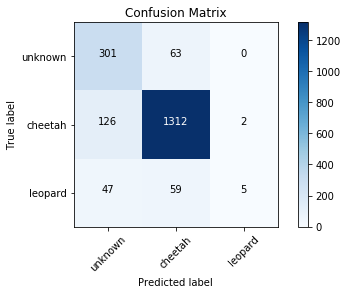

In [38]:
plot_confusion_matrix(cm, classes, title="Confusion Matrix")

# set all cheetahs to 1, all other to zero:
valid_labels_auc = np.copy(valid_labels)
np.place(valid_labels_auc, valid_labels_auc == 2, 0)

roc_score = roc_auc_score(valid_labels_auc, predictions[:,1])
print(roc_score)

## Pretrained network

Lade nun ein auf Imagenet vortrainiertes Netzwerk und klassifiziere damit die Validierungsdaten. Eine Anleitung für keras findest du hier: https://keras.io/applications

Du kannst selber entscheiden, welche Netzwerkarchitektur du verwendest.

In [40]:
# use pre-trained vgg16 model, which comes with keras 
vgg16_model = VGG16(weights='imagenet')
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Da der ImageNet-Datensatz auch die Klassen cheetah und leopard enthält, können wir sogar ohne transfer learning das vortrainierte Netzwerk evaluieren. Interpretiere alle Klassen außer cheetah und leopard als unknown und berechne wie im vorherigen Schritt die Confusion matrix und den ROC AUC score für die Klasse cheetah.

In [47]:
# 293: 'cheetah, chetah, Acinonyx jubatus'
# 288: 'leopard, Panthera pardus'
vgg_predictions = vgg16_model.predict_generator(valid_batches)

In [48]:
valid_labels = valid_batches.classes
print(valid_labels.shape, vgg_predictions.shape)

(1915,) (1915, 1000)


Confusion matrix, without normalization
[[ 364    0    0]
 [1178  253    9]
 [  99    9    3]]
0.6265950292397661


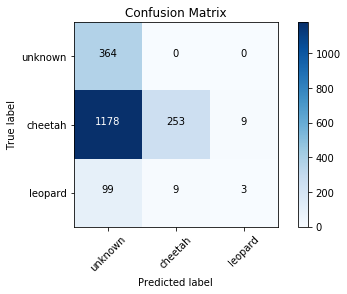

In [52]:
# print(classes)

vgg16_predictions = vgg_predictions.argmax(axis=1)

# replace all unknown classes with a zero:
np.place(vgg16_predictions, vgg16_predictions == 1, 0)
np.place(vgg16_predictions, vgg16_predictions == 2, 0)
np.place(vgg16_predictions, vgg16_predictions == 293, 1)
np.place(vgg16_predictions, vgg16_predictions == 288, 2)
np.place(vgg16_predictions, vgg16_predictions > 2, 0)

# print(valid_labels.shape, vgg16_predictions.shape)

vgg_cm = confusion_matrix(valid_labels, vgg16_predictions)
plot_confusion_matrix(vgg_cm, classes, title="Confusion Matrix")

# ROC AUC Score
# set all cheetahs to 1, all other to zero:
valid_labels_auc = np.copy(valid_labels)
np.place(valid_labels_auc, valid_labels_auc == 2, 0)

roc_score = roc_auc_score(valid_labels_auc, vgg_predictions[:, 1])
print(roc_score)


## Transfer learning

Das vortrainierte Netzwerk kann nun mit unseren Daten weitertrainiert werden. Ersetze dafür das letzte Layer in dem Netzwerk mit einem Dense Layer mit 3 Ausgaben für unsere Klassen cheetah, leopard und unknown. Du kannst selbst entscheiden, ob du nun das komplette Netzwerk mit trainierst oder nur das neu eingefügte, letzte Layer.

Auch hierfür kannst du dich wieder an der keras Anleitung orientieren: https://keras.io/applications

In [53]:
custom_model = Sequential()
for layer in vgg16_model.layers:
    custom_layer = layer
    custom_layer.trainable = False
    custom_model.add(custom_layer)
    
custom_model.layers.pop()
# add a fully connected layer with 3 outputs, each for one category
custom_model.add(Dense(3, activation="softmax"))
custom_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [54]:
custom_model.compile(loss='categorical_crossentropy',
              #optimizer=optimizers.Adam(lr=0.001),
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])


In [55]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
custom_model.fit_generator(
        train_batches,
        steps_per_epoch = 1800 // batch_size,
        epochs=50,
        validation_data = valid_batches,
        validation_steps = 250 // batch_size)


In [56]:
#model.save('models/custom-model-7506.h5')
#model.save_weights('models/custom-model-weights-7506.h5')
model.load_weights('models/custom-model-weights-7506.h5')

Evaluiere das so trainierte Netzwerk wie in den letzten beiden Aufgaben.

In [60]:
print(classes)
custom_model_predictions = custom_model.predict_generator(valid_batches)

('unknown', 'cheetah', 'leopard')


In [61]:
valid_labels = valid_batches.classes

# ROC AUC Score
# set all cheetahs to 1, all other to zero:
valid_labels_auc = np.copy(valid_labels)
roc_predictions = np.copy(custom_model_predictions)
np.place(valid_labels_auc, valid_labels_auc == 2, 0)

roc_score = roc_auc_score(valid_labels_auc, roc_predictions[:, 1])
print(roc_score)

custom_model_predictions = custom_model_predictions.argmax(axis=1)

0.5825387426900585


Confusion matrix, without normalization
[[ 27 136 201]
 [ 40 694 706]
 [  4  61  46]]


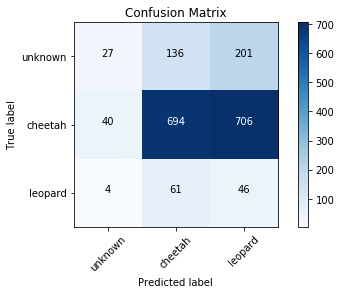

In [62]:
# print(valid_labels.shape, custom_model_predictions.shape)
custom_model_cm = confusion_matrix(valid_labels, custom_model_predictions)
plot_confusion_matrix(custom_model_cm, classes, title="Confusion Matrix")

## Auswertung

Beschreibe kurz qualitativ die Resultate. Wie unterscheiden sich die trainierten Netzwerke, zum Beispiel im Bezug auf die Genauigkeit oder die Laufzeit? Welche Entscheidungen musstest du bei der Erfüllung der Aufgaben treffen und warum hast du dich für den von dir gewählten Weg entschieden?

Die Trainingsdatensätze sind wie folgt aufgeteilt:
 - 11.534 Datensätze für die Klasse Cheetah
 -  1.300 Datensätze für die Klasse Leopard
 -  4.963 Datensätze für die Klasse Unknown

Die Validation Datensätze sind wie folgt aufgeteilt:
 - 1.440 Datensätze für die Klasse Cheetah
 -  111 Datensätze für die Klasse Leopard
 -  364 Datensätze für die Klasse Unknown
 - 1.915 Datensätze insgesamt

Gehen wir davon aus, dass ein Algorithmus alle Datensätze als Cheetah beurteilt, erreicht dieser damit aufgrund der Verteilung in unseren Datensätzen bereits eine Genauigkeit von ungefähr 75%.

In dem ersten Lösungsansatz (dem eigenen Netz) wird die große Bildauflösung zu Beginn durch Max-Pooling und einer Convolution mit einer Stride von 2 reduziert. In der Confusion Matrix kann man erkennen, dass die Accuracy auf dem Validation-Set gering ist. 

Das VGG16-Netz erkennt einige Klassen. Da hier kein Training notwendig gewesen ist, ist der Arbeitsaufwand vergleichsweise gering gewesen.

Das angepasste VGG16-Netz hat eine eher mäßige Accuracy.

